# Qolor Qoding

## Load Image and Reduce Possible Values

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

In [2]:
N_QUBITS = 5 # How many qubits do you want to use? Max 8

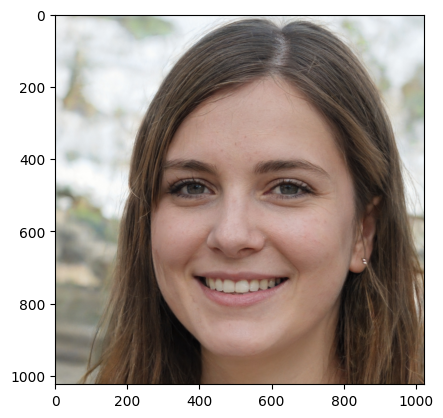

In [3]:
org_image = mpimg.imread('./images/Woman.jpg')
plt.imshow(org_image)

Here we can reduce the number of possible values for the image. If you call the function with `r_value = 2**x`, it guarantees that if you convert your pixel values to binary the last x bits will be zero. This hardly affects the image quality but reduces the number of qubits and hugely decreases the computational complexity of the mapping. Should also make the quantum image smoother. 

In [4]:
def reduce_rgb_values(image, r_value):
    height, width, channel = image.shape
    for h in range(height):
        for w in range(width):
            for c in range(channel):
                value = image[h, w, c]
                difference = value % r_value
                if difference < r_value/2:
                    value -= difference
                else:
                    value += (r_value - difference)
                if value > 255:
                    value -= r_value
                image[h, w, c] = value
                
    return image

array([[224, 232, 224],
       [224, 232, 232],
       [232, 232, 232],
       ...,
       [224, 232, 232],
       [224, 224, 232],
       [216, 224, 224]], dtype=uint8)

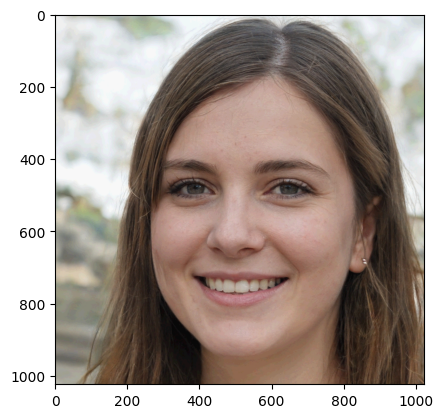

In [5]:
image = reduce_rgb_values(copy(org_image), 2**(8-N_QUBITS))
plt.imshow(image)
image[1, :, :]

In case you only want to transform only a part of your image (in form of a rectangle), change its top left coordinates, its width and its height

In [6]:
print(org_image.shape)
# default values, do not change
rect_top_left = (0, 0)
width, height = org_image.shape[0], org_image.shape[1]

(1024, 1024, 3)


In [7]:
# Change here
rect_top_left = (300, 0)
width, height = 150, 1024

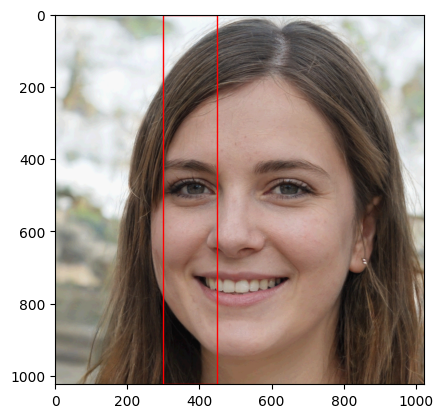

In [8]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(image)
rect = patches.Rectangle(rect_top_left, width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

## Qiskit Stuff

made by a pennylane user 

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit import Aer
from qiskit.circuit.random import random_circuit 
from qiskit.providers.fake_provider import FakeManilaV2, FakeBoeblingen, FakeMelbourne

Create your personal ciruit. Greater depth will increase the transformation of your image. 

In [10]:
noisy_circuit = QuantumCircuit(N_QUBITS)

personal_circuit = random_circuit(N_QUBITS, depth=4, max_operands=3, seed=1337)

# insert real circuit code instead of a randomly generated one


REPS = 2 # how often do you want to repeat your circuit ?

In [11]:
for i in range(REPS):
    noisy_circuit.compose(personal_circuit, inplace=True)
    noisy_circuit.barrier()
    noisy_circuit.compose(personal_circuit.inverse(), inplace=True)
    noisy_circuit.barrier()
    

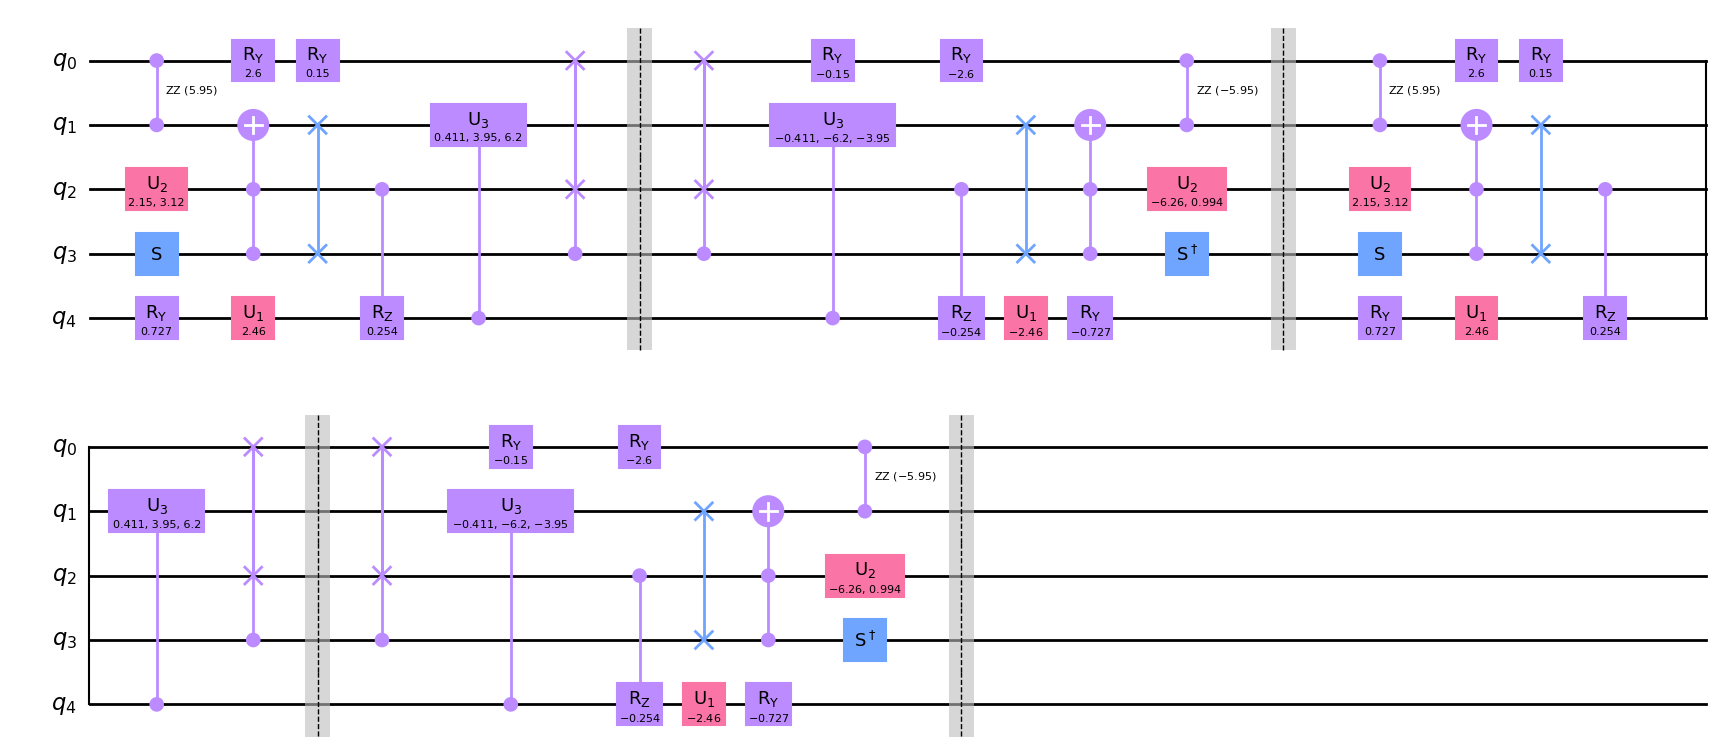

In [12]:
noisy_circuit.draw()

### some helper functions for the transformation

In [13]:
def filling_zeros(binary, n):
    difference = (n - len(binary))*"0"
    return difference + binary

In [14]:
def create_mapping(backend, shots):
    mapping = {}

    for i in range(2**N_QUBITS):
        encoding_circuit = QuantumCircuit(N_QUBITS)
        binary_number = bin(i)[2:]
        for index, q in enumerate(binary_number[::-1]): #LSB = Qubit 0
            if q == "1":
                encoding_circuit.x(index)
        encoding_circuit.barrier()

        full_circuit = encoding_circuit.compose(noisy_circuit)
        full_circuit.measure_all()

        job_sim = backend.run(transpile(full_circuit, backend), shots=shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(full_circuit)
        mapping[filling_zeros(binary_number, N_QUBITS)] = max(counts, key=counts.get)

    print(mapping)
    return mapping

In [15]:
def convert_image(image, mapping):
    channel = image.shape[2]
    for h in range(rect_top_left[1], rect_top_left[1]+height):
        for w in range(rect_top_left[0], rect_top_left[0]+width):
            for c in range(channel):
                value = image[h, w, c]
                b_value = bin(value)[2:]
                b_value2 = filling_zeros(b_value, 8)
                
                cut_b_value = b_value2[:N_QUBITS]
                new_b_value = mapping[cut_b_value] + (8-N_QUBITS)*"0"
                
                image[h, w, c] = int(new_b_value, 2)
                
    return image

## Create your own quantum image!

{'00000': '01000', '00001': '00100', '00010': '00101', '00011': '00011', '00100': '00100', '00101': '00001', '00110': '00000', '00111': '00000', '01000': '10001', '01001': '00100', '01010': '00110', '01011': '00100', '01100': '01111', '01101': '00001', '01110': '01010', '01111': '01001', '10000': '10101', '10001': '10001', '10010': '11010', '10011': '01111', '10100': '00100', '10101': '11111', '10110': '10000', '10111': '10010', '11000': '10001', '11001': '10001', '11010': '11011', '11011': '01011', '11100': '11000', '11101': '11001', '11110': '10101', '11111': '10101'}


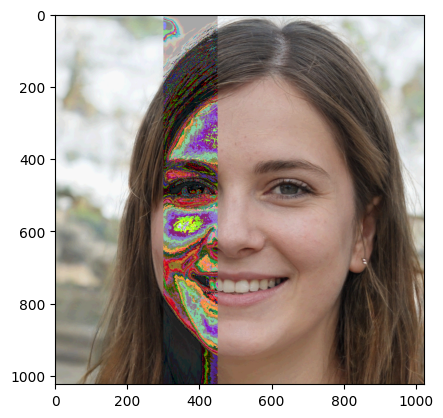

In [18]:
backend = FakeMelbourne()
# backend = Aer.get_backend('qasm_simulator') # same image as output
shots = 32

mapping = create_mapping(backend, shots)
q_image = convert_image(copy(image), mapping)
plt.imshow(q_image)